<h1> Тестовое задание в Osmoview на позицию Junior CV Engineer

**Задача:** Классифицировать, есть или нет св. Георгий на изображении.

## Необходимые вещи для работы кода: импорт библиотек и обеспечение воспроизводимости.##
Для управления зависимостями была использована conda, файл для программного окружения -- environment.yml

In [1]:
# Импортируем необходимые библиотеки и функции
import os
from data_preprocessing import prepare_datasets, get_dataloaders
import timm
from model_fine_tuning import train, train_stats, model_test
from data_mining import get_data_from_df
import torch

In [2]:
# Устанавливаем random seeds и обеспечиваем детерминированность, где возможно, чтобы наш эксперимент был воспроизводим

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Загрузка данных и их предобработка##

Нужные .csv файлы должны лежать в директории './data'

In [3]:
# Подгружаем данные, используя выданные датафреймы со ссылками на картинки
path_to_data = os.path.join('D:', 'test_case_data')
get_data_from_df('georges', 'georges', path_to_data)
get_data_from_df('non_georges', 'non_georges', path_to_data)


KeyboardInterrupt



In [4]:
# Собираем картинки в датасеты для обучения, валидации модели и тестинга


train_dataset, val_dataset, test_dataset, c_to_i, label_counts = prepare_datasets(path_to_data, stats=True, return_counts=True)


There are 2 classes in the dataset.
 There are 4104 samples in the train dataset
 There are 456 in the validation dataset
 There are 1140 in the test dataset
 Class ratio: 0.7065868263473054


Так как у нас классы несбалансированны, посчитаем веса для функции потерь, чтобы вес ошибки на менее представленном классе был больше.

In [5]:
loss_weights = None

In [6]:
# взвешивание кдассов. Для отсутствия учета взвешивания по классам, не запускайте эту ячейку
len_dataset = torch.sum(torch.from_numpy(label_counts))

loss_weights = torch.tensor([1-(label_counts[0]/len_dataset), label_counts[0]/len_dataset])

## Загрузка модели ##

Так как существует множество моделей для компьютерного зрения, проще и быстрее будет дообучить какую-то уже существующую и предобученную модель для поставленной задачи. Фактически здесь поставлена задача переноса обучения (Transfer Learning). Поэтому первым шагом нужно понять, какую модель стоит использовать.

Рассмотрев этот пост: https://encord.com/blog/top-computer-vision-models/ в качестве источника, и посмотрев, какие модели можно использовать в уже предобученном состоянии, была выбрана  модель DAViT, поскольку, ее просто достать и это унимодальный классификатор изображений (в отличие от, например, CoCa или PaLi, которые используют LLM).

На ImageNet-1k она получала точность (accuracy) в 90.4% на тестовом наборе.

Для решения нашей задачи у исходной модели (Предобучена на ImageNet-1k) был изменен последний слой: с torch.nn.Linear(1024,1000) на torch.nn.Linear(1024, 2). Также был проведен эксперимент с более сложной конструкцией: когда выходному полносвязному слой предшестовал слой субдискретизации (avgPooling), но в данном случае, accuracy падала.

Так как мы хотим дообучить модель, и сделать это относительно быстро, то было принято решение заморозить все слои кроме последнего полносвязного слоя и обучать только его.

In [7]:
model = timm.create_model('davit_base', pretrained=True) # скачиваем модель

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # смотрим, можно ли перетащить модель на видеокарту

if type(loss_weights) == torch.Tensor: # проверим, есть ли взвешиваения по классам
    loss_weights = loss_weights.to(device)

train_loader, val_loader, test_loader = get_dataloaders(train_dataset, val_dataset, test_dataset)

model.head.fc = torch.nn.Linear(in_features=1024, out_features=2, bias=True) # меняем слой под нашу задачу

for name, param in model.named_parameters(): # замораживаем все слои, кроме последнего
    if 'head.fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

## Обучение модели ##

Для обучения модели решению данной задачи была использована стандартная для таких задач функция потерь -- функция перекрестной энтропии

In [8]:
criterion = torch.nn.CrossEntropyLoss(weight=loss_weights) # учитываем несбалансированность наших классов
scaler = torch.amp.GradScaler(device) # скейлер нам тут не очень нужен, поскольку градиенты за один слой не растворятся, но предосторожности ради оставим
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
model.to(device)
epochs = 10
all_loses, val_loses, accuracies, best_model = train(model, train_loader, val_loader,
                                                     epochs, criterion, scaler, optimizer, scheduler,
                                                     device=device)

model_test(model, test_dataset, test_loader, device) # Посчитаем точность на тестовой выборке

Epoch: 1, Training Loss: 0.00, Validation Loss: 0.3887, accuracy = 1.0000
Epoch: 2, Training Loss: 0.00, Validation Loss: 0.3439, accuracy = 1.0000
Epoch: 3, Training Loss: 0.00, Validation Loss: 0.3278, accuracy = 0.8750
Epoch: 4, Training Loss: 0.00, Validation Loss: 0.3213, accuracy = 0.8750
Epoch: 5, Training Loss: 0.00, Validation Loss: 0.3223, accuracy = 0.8750
Epoch: 6, Training Loss: 0.00, Validation Loss: 0.3094, accuracy = 1.0000
Epoch: 7, Training Loss: 0.00, Validation Loss: 0.3059, accuracy = 1.0000
Epoch: 8, Training Loss: 0.00, Validation Loss: 0.3035, accuracy = 1.0000
Epoch: 9, Training Loss: 0.00, Validation Loss: 0.3024, accuracy = 1.0000
Epoch: 10, Training Loss: 0.00, Validation Loss: 0.3007, accuracy = 1.0000
Test Accuracy:  0.8929824561403509


0.8929824561403509

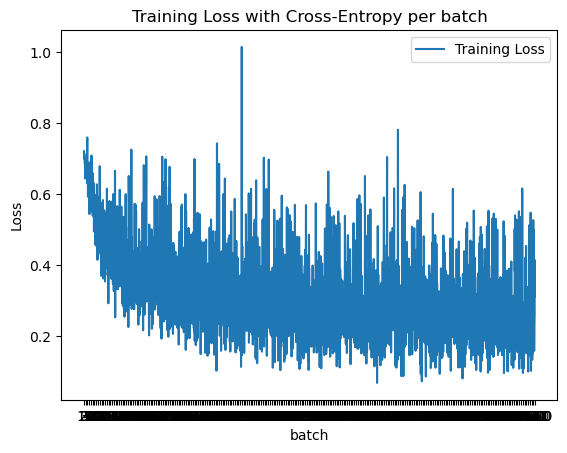

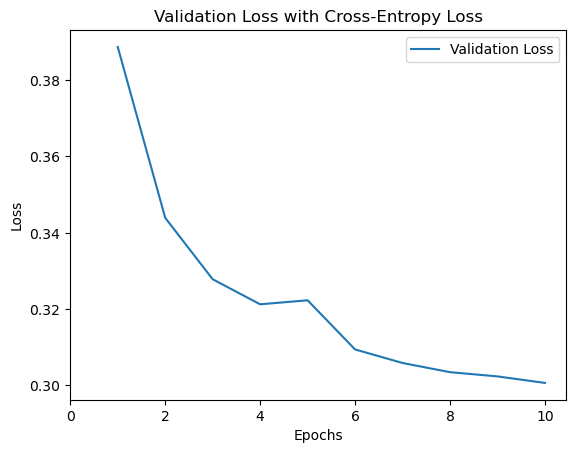

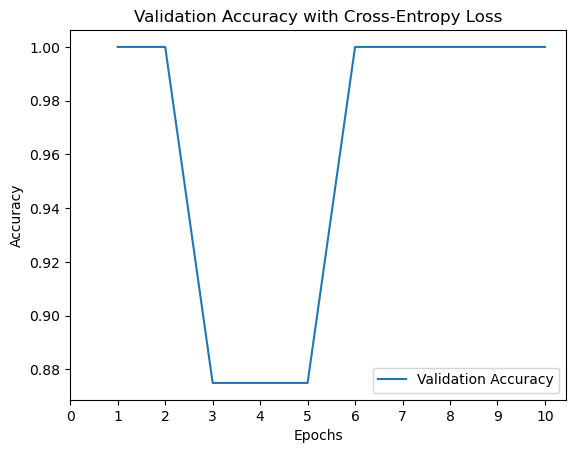

In [9]:
train_stats(all_loses, val_loses, accuracies, epochs) # Нарисуем, что получилось для функций потерь и точности на валидационной выборке

In [10]:
model.load_state_dict(best_model) # берем лучшую модель с точки зрения классификации валидационной выборки и посчитаем на ее точность на тесте

model_test(model, test_dataset, test_loader, device) # Посчитаем точность на тестовой выборке

Test Accuracy:  0.8929824561403509


0.8929824561403509

По локальным экспериментам была достигнута точность(accuracy) на тестовой выборке в 89.9% (причем в функции потерь классы были невзвешены) и 89.8% при учете взвешивания классов.
Ожидаемая точность по результатам всего эксперимента, приведенного в ноутбуке: 88-89 процентов на тестовом наборе

In [11]:
# сохраним лучшую модель

torch.save(best_model, '.\models\model_best.pt')